In [1]:
import wikipedia as wiki
import pandas as pd
import re
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# Sentiment Analysis

In [2]:
woman = wiki.page("Woman")
female = wiki.page("Femaless")
femininity = wiki.page("Femininity")
feminism = wiki.page("Feminism")
nb = wiki.page("Non-binary gender")
man = wiki.page("Mann")
male = wiki.page("MALES")
masculinity = wiki.page("Masculinity")

In [3]:
womantext = woman.content
femaletext = female.content
femininitytext = femininity.content
feminismtext = feminism.content
nbtext = nb.content
mantext = man.content
maletext = male.content
masculinitytext = masculinity.content

## Flair

In [4]:
classifier = TextClassifier.load('en-sentiment')

In [5]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    
     # Remove headlines
    result = re.sub("==[^=]*==", '', result)

    # Fix sentence spacing
    result = re.sub(r'\.([A-Z])', r'. \1', result)
    
    return result

In [6]:
def make_sentences(text):
    """ Break apart text into a list of sentences """
    cleaned_text = text.replace("=", "")
    sentences = [sent for sent in split_single(cleaned_text) if sent.strip()]
    return sentences

In [7]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    if hasattr(text, 'labels') and len(text.labels) > 0:
        label = text.labels[0]
        value = label.value
        score = label.score
        if value == 'POSITIVE':
            result = score
        else:
            result = -score
        return round(result, 3)
    else:
        # Handle case where no prediction was made
        return 0

In [8]:
def get_scores(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

def get_sum(scores):
    
    result = round(sum(scores), 3)
    return result

In [9]:
data = {'Gender': ["Man", "Woman", "Non Binary"], 'text': [mantext, womantext, nbtext]}
df = pd.DataFrame(data=data)
df = df.dropna()
df = df.reset_index(drop=True)
df.text = df.text.apply(clean)
df['sentences'] = df.text.apply(make_sentences)
df['scores'] = df['sentences'].apply(get_scores)
df['scores_sum'] = df.scores.apply(get_sum)
df['scores_avg'] = df.apply(lambda row: row['scores_sum'] / len(row['scores']), axis=1)

In [10]:
df

,Gender,text,sentences,scores,scores_sum,scores_avg
0,Man,A man is an adult male human. Prior to adultho...,"[A man is an adult male human., Prior to adult...","[0.812, -0.719, 0.553, -0.818, 0.995, -0.878, ...",-4.183,-0.032937
1,Woman,A woman is an adult female human. Prior to adu...,"[A woman is an adult female human., Prior to a...","[0.542, -0.69, -0.736, 0.985, -1.0, 0.985, -0....",7.908,0.035147
2,Non Binary,Non-binary and genderqueer are umbrella terms ...,[Non-binary and genderqueer are umbrella terms...,"[0.593, 0.802, -0.651, 0.958, -0.973, -0.926, ...",-37.818,-0.293163


## Investigating Judgements

In [11]:
# Get the first row of the dataframe
row = df.iloc[0]

# Get the sentences and scores from the row
sentences = row['sentences']
scores = row['scores']

# Find the indices of the negative scores
negative_indices = [i for i, score in enumerate(scores) if score < 0]

# Get the sentences with negative scores and their respective scores
negative_sentences = [sentences[i] for i in negative_indices]
negative_scores = [scores[i] for i in negative_indices]

# Print out the sentences with negative scores and their respective scores
for sentence, score in zip(negative_sentences, negative_scores):
    print(f"{sentence} (score: {score})")

Prior to adulthood, a male human is referred to as a boy (a male child or adolescent). (score: -0.719)
Sex differentiation of the male fetus is governed by the SRY gene on the Y chromosome. (score: -0.818)
These include greater muscle mass, the growth of facial hair and a lower body fat composition. (score: -0.878)
Throughout human history, traditional gender roles have often defined and limited men's activities and opportunities. (score: -0.671)
Men often face conscription into military service or are directed into professions with high mortality rates. (score: -0.908)
Many religious doctrines stipulate certain rules for men, such as religious circumcision. (score: -0.78)
Men are over-represented as both perpetrators and victims of violence. (score: -0.992)
Trans men have a gender identity that does not align with their female sex assignment at birth, while intersex men may have sex characteristics that do not fit typical notions of male biology. (score: -0.999)
The Old English form p

In [12]:
def sentiment_analysis(gender):
    df_gender = df[df['Gender'] == gender]
    neg = 0
    neu = 0
    pos = 0
    for scores in df_gender['scores']:
        for score in scores:
            if score <= -0.2:
                neg += 1
            elif score >= 0.2:
                pos += 1
            else:
                neu += 1
    total = neg + neu + pos
    neg_percent = round((neg / total) * 100, 1)
    neu_percent = round((neu / total) * 100, 1)
    pos_percent = round((pos / total) * 100, 1)
    
    print(f"Overall sentiment dictionary is : {{'neg': {neg_percent/100}, 'neu': {neu_percent/100}, 'pos': {pos_percent/100}}}")
    print(f"Text was rated as {neg_percent} % Negative")
    print(f"Text was rated as {neu_percent} % Neutral")
    print(f"Text was rated as {pos_percent} % Positive")
    
    if neg_percent > pos_percent:
        print("Text Overall Rated As Negative")
    elif pos_percent > neg_percent:
        print("Text Overall Rated As Positive")
    else:
        print("Text Overall Rated As Neutral")

In [13]:
sentiment_analysis("Man")

Overall sentiment dictionary is : {'neg': 0.52, 'neu': 0.0, 'pos': 0.48}
Text was rated as 52.0 % Negative
Text was rated as 0.0 % Neutral
Text was rated as 48.0 % Positive
Text Overall Rated As Negative


In [14]:
sentiment_analysis("Woman")

Overall sentiment dictionary is : {'neg': 0.489, 'neu': 0.0, 'pos': 0.511}
Text was rated as 48.9 % Negative
Text was rated as 0.0 % Neutral
Text was rated as 51.1 % Positive
Text Overall Rated As Positive


In [15]:
sentiment_analysis("Non Binary")

Overall sentiment dictionary is : {'neg': 0.659, 'neu': 0.0, 'pos': 0.341}
Text was rated as 65.9 % Negative
Text was rated as 0.0 % Neutral
Text was rated as 34.1 % Positive
Text Overall Rated As Negative


## AFINN

In [16]:
afn = Afinn()

In [17]:
data = {'Gender': ["Man", "Male", "Masculinity", "Woman", "Female", "Femininity", "Feminism", "Non Binary"], 'text': [mantext, maletext, masculinitytext, womantext, femaletext, femininitytext, feminismtext, nbtext]}
df = pd.DataFrame(data=data)
df.text = df.text.apply(clean)
df['sentences'] = df.text.apply(make_sentences)

In [18]:
# compute scores (polarity) and labels
scores = []
positive_percentages = []
negative_percentages = []
neutral_percentages = []
for index, row in df.iterrows():
    row_scores = [afn.score(sentence) for sentence in row['sentences']]
    scores.append(row_scores)
    
    sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in row_scores]
    positive_percentage = sentiments.count('positive') / len(sentiments)
    negative_percentage = sentiments.count('negative') / len(sentiments)
    neutral_percentage = sentiments.count('neutral') / len(sentiments)
    
    positive_percentages.append(positive_percentage)
    negative_percentages.append(negative_percentage)
    neutral_percentages.append(neutral_percentage)

# add new columns to the dataframe
df['scores'] = scores
df['positive_percentage'] = positive_percentages
df['negative_percentage'] = negative_percentages
df['neutral_percentage'] = neutral_percentages

In [19]:
df

,Gender,text,sentences,scores,positive_percentage,negative_percentage,neutral_percentage
0,Man,A man is an adult male human. Prior to adultho...,"[A man is an adult male human., Prior to adult...","[0.0, 0.0, 2.0, 0.0, 4.0, 5.0, 2.0, 1.0, 0.0, ...",0.251969,0.181102,0.566929
1,Male,Male (symbol: ♂) is the sex of an organism tha...,[Male (symbol: ♂) is the sex of an organism th...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, ...",0.301587,0.095238,0.603175
2,Masculinity,Masculinity (also called manhood or manliness)...,[Masculinity (also called manhood or manliness...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 2.0, 2.0, ...",0.161572,0.174672,0.663755
3,Woman,A woman is an adult female human. Prior to adu...,"[A woman is an adult female human., Prior to a...","[0.0, 0.0, 1.0, 1.0, -2.0, 2.0, 0.0, 0.0, 3.0,...",0.302222,0.271111,0.426667
4,Female,An organism's sex is female (symbol: ♀) if it ...,[An organism's sex is female (symbol: ♀) if it...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.176471,0.102941,0.720588
5,Femininity,Femininity (also called womanliness) is a set ...,[Femininity (also called womanliness) is a set...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -3.0, 0.0, 0.0,...",0.296000,0.224000,0.480000
6,Feminism,Feminism is a range of socio-political movemen...,[Feminism is a range of socio-political moveme...,"[0.0, 0.0, 2.0, -2.0, -7.0, 1.0, 0.0, 0.0, 0.0...",0.265748,0.222441,0.511811
7,Non Binary,Non-binary and genderqueer are umbrella terms ...,[Non-binary and genderqueer are umbrella terms...,"[0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 2.0...",0.193798,0.139535,0.666667


In [20]:
df.iloc[1]["sentences"]

['Male (symbol: ♂) is the sex of an organism that produces the gamete (sex cell) known as sperm, which fuses with the larger female gamete, or ovum, in the process of fertilization.',
 'A male organism cannot reproduce sexually without access to at least one ovum from a female, but some organisms can reproduce both sexually and asexually.',
 'Most male mammals, including male humans, have a Y chromosome, which codes for the production of larger amounts of testosterone to develop male reproductive organs.',
 'In humans, the word male can also be used to refer to gender, in the social sense of gender role or gender identity.',
 'The use of "male" in regards to sex and gender has been subject to discussion.',
 'The existence of separate sexes has evolved independently at different times and in different lineages, an example of convergent evolution.',
 'The repeated pattern is sexual reproduction in isogamous species with two or more mating types with gametes of identical form and behavior

## Generating Output

In [21]:
def generate_sentiment_report(df, gender):
    # filter rows by gender
    df = df[df['Gender'] == gender]
    
    # calculate overall sentiment percentages
    total_positive_percentage = df['positive_percentage'].mean()
    total_negative_percentage = df['negative_percentage'].mean()
    total_neutral_percentage = df['neutral_percentage'].mean()
    
    # create sentiment dictionary
    sentiment_dict = {
        'neg': round(total_negative_percentage, 3),
        'neu': round(total_neutral_percentage, 3),
        'pos': round(total_positive_percentage, 3)
    }
    
    # generate report
    report = f"Overall sentiment dictionary for gender {gender} is : {sentiment_dict}\n"
    report += f"Text was rated as {round(sentiment_dict['neg']*100, 1)} % Negative\n"
    report += f"Text was rated as {round(sentiment_dict['neu']*100, 1)} % Neutral\n"
    report += f"Text was rated as {round(sentiment_dict['pos']*100, 1)} % Positive\n"
    
    if sentiment_dict['pos'] > sentiment_dict['neg']:
        report += f"Text Overall Rated As Positive for gender {gender}"
    elif sentiment_dict['pos'] < sentiment_dict['neg']:
        report += f"Text Overall Rated As Negative for gender {gender}"
    else:
        report += f"Text Overall Rated As Neutral for gender {gender}"
    
    return report

In [22]:
print(generate_sentiment_report(df, 'Man'))

Overall sentiment dictionary for gender Man is : {'neg': 0.181, 'neu': 0.567, 'pos': 0.252}
Text was rated as 18.1 % Negative
Text was rated as 56.7 % Neutral
Text was rated as 25.2 % Positive
Text Overall Rated As Positive for gender Man


In [23]:
print(generate_sentiment_report(df, 'Woman'))

Overall sentiment dictionary for gender Woman is : {'neg': 0.271, 'neu': 0.427, 'pos': 0.302}
Text was rated as 27.1 % Negative
Text was rated as 42.7 % Neutral
Text was rated as 30.2 % Positive
Text Overall Rated As Positive for gender Woman


In [24]:
print(generate_sentiment_report(df, 'Non Binary'))

Overall sentiment dictionary for gender Non Binary is : {'neg': 0.14, 'neu': 0.667, 'pos': 0.194}
Text was rated as 14.0 % Negative
Text was rated as 66.7 % Neutral
Text was rated as 19.4 % Positive
Text Overall Rated As Positive for gender Non Binary


In [25]:
print(generate_sentiment_report(df, 'Male'))

Overall sentiment dictionary for gender Male is : {'neg': 0.095, 'neu': 0.603, 'pos': 0.302}
Text was rated as 9.5 % Negative
Text was rated as 60.3 % Neutral
Text was rated as 30.2 % Positive
Text Overall Rated As Positive for gender Male


In [26]:
print(generate_sentiment_report(df, 'Female'))

Overall sentiment dictionary for gender Female is : {'neg': 0.103, 'neu': 0.721, 'pos': 0.176}
Text was rated as 10.3 % Negative
Text was rated as 72.1 % Neutral
Text was rated as 17.6 % Positive
Text Overall Rated As Positive for gender Female


In [27]:
print(generate_sentiment_report(df, 'Femininity'))

Overall sentiment dictionary for gender Femininity is : {'neg': 0.224, 'neu': 0.48, 'pos': 0.296}
Text was rated as 22.4 % Negative
Text was rated as 48.0 % Neutral
Text was rated as 29.6 % Positive
Text Overall Rated As Positive for gender Femininity


In [28]:
print(generate_sentiment_report(df, 'Feminism'))

Overall sentiment dictionary for gender Feminism is : {'neg': 0.222, 'neu': 0.512, 'pos': 0.266}
Text was rated as 22.2 % Negative
Text was rated as 51.2 % Neutral
Text was rated as 26.6 % Positive
Text Overall Rated As Positive for gender Feminism


In [29]:
print(generate_sentiment_report(df, 'Masculinity'))

Overall sentiment dictionary for gender Masculinity is : {'neg': 0.175, 'neu': 0.664, 'pos': 0.162}
Text was rated as 17.5 % Negative
Text was rated as 66.4 % Neutral
Text was rated as 16.2 % Positive
Text Overall Rated As Negative for gender Masculinity


## Split into Sections

In [30]:
def clean_and_split(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub('\n', '', result)
    result = re.sub(r'\.([A-Z])', r'. \1', result)

    # Split text according to headlines
    split_text = re.split(r'==\s(.+?)\s==', result)

    # Create list of tuples
    tuples_list = []

    # Assign "Introduction" as the headline for the first paragraph
    if len(split_text) > 0:
        introduction_text = make_sentences(split_text[0])
        tuples_list.append(("Introduction", introduction_text))

    # Filter out unwanted sections
    unwanted_sections = ["See also", "References", "Further reading", "External links", "Explanatory notes"]
    for i in range(1, len(split_text), 2):
        headline = split_text[i]
        text = split_text[i + 1] if i + 1 < len(split_text) else ''
        if headline not in unwanted_sections:
            sentences = make_sentences(text)
            tuples_list.append((headline, sentences))
        
    return tuples_list

In [31]:
data = {'Gender': ["Man", "Male", "Masculinity", "Woman", "Female", "Femininity", "Feminism", "Non Binary"], 'text': [mantext, maletext, masculinitytext, womantext, femaletext, femininitytext, feminismtext, nbtext]}
df = pd.DataFrame(data=data)
df.text = df.text.apply(clean_and_split)

In [32]:
df.iloc[1]["text"]

[('Introduction',
  ['Male (symbol: ♂) is the sex of an organism that produces the gamete (sex cell) known as sperm, which fuses with the larger female gamete, or ovum, in the process of fertilization.',
   'A male organism cannot reproduce sexually without access to at least one ovum from a female, but some organisms can reproduce both sexually and asexually.',
   'Most male mammals, including male humans, have a Y chromosome, which codes for the production of larger amounts of testosterone to develop male reproductive organs.',
   'In humans, the word male can also be used to refer to gender, in the social sense of gender role or gender identity.',
   'The use of "male" in regards to sex and gender has been subject to discussion.']),
 ('Overview',
  ['The existence of separate sexes has evolved independently at different times and in different lineages, an example of convergent evolution.',
   'The repeated pattern is sexual reproduction in isogamous species with two or more mating t

In [33]:
# Create empty lists to store the results
gender_list = []
headline_list = []
sentences_list = []
scores_list = []
positive_percentages = []
negative_percentages = []
neutral_percentages = []

# Iterate over the rows in the dataframe
for index, row in df.iterrows():
    gender = row['Gender']
    text_tuples = row['text']
    
    # Iterate over the paragraphs in the text
    for headline, sentences in text_tuples:
        # Compute scores and sentiments for each paragraph
        paragraph_scores = [afn.score(sentence) for sentence in sentences]
        paragraph_sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in paragraph_scores]
        
        if paragraph_sentiments:
            positive_percentage = paragraph_sentiments.count('positive') / len(paragraph_sentiments)
            negative_percentage = paragraph_sentiments.count('negative') / len(paragraph_sentiments)
            neutral_percentage = paragraph_sentiments.count('neutral') / len(paragraph_sentiments)
        else:
            positive_percentage = 0
            negative_percentage = 0
            neutral_percentage = 0
        
        # Append the data to the lists
        gender_list.append(gender)
        headline_list.append(headline)
        sentences_list.append(sentences)
        scores_list.append(paragraph_scores)
        positive_percentages.append(positive_percentage)
        negative_percentages.append(negative_percentage)
        neutral_percentages.append(neutral_percentage)

# Create a new dataframe
new_df = pd.DataFrame({
     'Gender': gender_list,
    'Headline': headline_list,
    'sentences': sentences_list,
    'scores': scores_list,
    'positive_percentage': positive_percentages,
    'negative_percentage': negative_percentages,
    'neutral_percentage': neutral_percentages
})

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

In [34]:
new_df

,Gender,Headline,sentences,scores,positive_percentage,negative_percentage,neutral_percentage
0,Man,Introduction,"[A man is an adult male human., Prior to adult...","[0.0, 0.0, 2.0, 0.0, 4.0, 5.0, 2.0, 1.0, 0.0, ...",0.583333,0.083333,0.333333
1,Man,Etymology,"[The English term ""man"" is derived from the Pr...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.000000
2,Man,Biology,"[In humans, sperm cells carry either an X or a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, ...",0.187500,0.000000,0.812500
3,Man,Reproductive system,[The male reproductive system includes externa...,"[0.0, 0.0, 0.0, -1.0, 0.0]",0.000000,0.200000,0.800000
4,Man,Sex hormones,[Testosterone stimulates the development of th...,"[1.0, 0.0, 1.0]",0.666667,0.000000,0.333333
...,...,...,...,...,...,...,...
172,Non Binary,Brazil,[A 2021 survey published in Scientific Reports...,"[0.0, 0.0]",0.000000,0.000000,1.000000
173,Non Binary,Canada,"[In April 2022, Statistics Canada released fin...","[0.0, 2.0, 0.0]",0.333333,0.000000,0.666667
174,Non Binary,Switzerland,[A 2021 survey found that 0.4% of adults in Sw...,"[0.0, 0.0]",0.000000,0.000000,1.000000
175,Non Binary,United Kingdom,[A 2011 survey conducted by the Equality and H...,"[0.0, 2.0, 0.0, 0.0]",0.250000,0.000000,0.750000


In [35]:
def fuse_rows_by_headline(dataframe, gender, major_headlines):
    fused_data = []
    fuse_flag = False
    fused_sentences = []
    fused_headline = ""
    scores = []
    
    for index, row in dataframe.iterrows():
        if row['Gender'] == gender:
            if row['Headline'] in major_headlines:
                if fuse_flag:
                    fused_data.append([gender, fused_headline, fused_sentences, scores])
                    fused_sentences = []
                    fused_headline = ""
                    scores = []
                
                fuse_flag = True
                fused_headline = row['Headline']
                fused_sentences.extend(row['sentences'])
                scores.extend(row['scores'])
            elif fuse_flag:
                fused_sentences.extend(row['sentences'])
                scores.extend(row['scores'])
    
    if fuse_flag:
        fused_data.append([gender, fused_headline, fused_sentences, scores])
    
    fused_df = pd.DataFrame(fused_data, columns=['Gender', 'Headline', 'text', 'scores'])
    
    # Recalculate percentages
    positive_percentages = []
    negative_percentages = []
    neutral_percentages = []
    
    for row in fused_df.iterrows():
        sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in row[1]['scores']]
        positive_percentage = sentiments.count('positive') / len(sentiments)
        negative_percentage = sentiments.count('negative') / len(sentiments)
        neutral_percentage = sentiments.count('neutral') / len(sentiments)
        
        positive_percentages.append(positive_percentage)
        negative_percentages.append(negative_percentage)
        neutral_percentages.append(neutral_percentage)
    
    fused_df['positive_percentage'] = positive_percentages
    fused_df['negative_percentage'] = negative_percentages
    fused_df['neutral_percentage'] = neutral_percentages
    
    return fused_df

In [36]:
gender = 'Female'
major_headlines = ['Introduction', 'Etymology and usage', 'Defining characteristics', 'Females across species', 'Sex determination', 'Evolution', 'Symbol']

female_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [37]:
female_df

,Gender,Headline,text,scores,positive_percentage,negative_percentage,neutral_percentage
0,Female,Introduction,[An organism's sex is female (symbol: ♀) if it...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.000000
1,Female,Etymology and usage,"[The word female comes from the Latin femella,...","[0.0, 0.0, -3.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.142857,0.857143
2,Female,Defining characteristics,"[Females produce ova, the larger gametes in a ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 1.0]",0.250000,0.125000,0.625000
3,Female,Females across species,[Species that are divided into females and mal...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...",0.066667,0.000000,0.933333
4,Female,Sex determination,[The sex of a particular organism may be deter...,"[2.0, 2.0, 0.0, 0.0, 0.0, 0.0, -2.0]",0.285714,0.142857,0.571429
5,Female,Evolution,[The question of how females evolved is mainly...,"[0.0, 0.0, 0.0, 4.0, 2.0, 2.0, 0.0, 0.0, 0.0, ...",0.304348,0.173913,0.521739
6,Female,Symbol,[The symbol ♀ (Unicode: U+2640 Alt codes: Alt+...,"[0.0, 3.0]",0.500000,0.000000,0.500000


In [38]:
gender = 'Male'
major_headlines = ['Introduction', 'Overview', 'Evolution', 'Symbol and usage', 'Males across species', 'Sex determination', 'Secondary sex characteristics']

male_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [39]:
male_df

,Gender,Headline,text,scores,positive_percentage,negative_percentage,neutral_percentage
0,Male,Introduction,[Male (symbol: ♂) is the sex of an organism th...,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.000000
1,Male,Overview,[The existence of separate sexes has evolved i...,"[0.0, 1.0, 3.0, 0.0, -1.0, 1.0]",0.500000,0.166667,0.333333
2,Male,Evolution,[The evolution of anisogamy led to the evoluti...,"[0.0, 0.0, 0.0, 0.0, -3.0, 0.0, 1.0, -2.0, 0.0...",0.090909,0.272727,0.636364
3,Male,Symbol and usage,[A common symbol used to represent the male se...,"[0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0]",0.222222,0.000000,0.777778
4,Male,Males across species,[Species that are divided into females and mal...,"[0.0, 0.0]",0.000000,0.000000,1.000000
5,Male,Sex determination,[The sex of a particular organism may be deter...,"[2.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, ...",0.473684,0.052632,0.473684
6,Male,Secondary sex characteristics,[Male animals have evolved to use secondary se...,"[1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0,...",0.500000,0.000000,0.500000


In [40]:
gender = 'Man'
major_headlines = ['Introduction', 'Etymology', 'Biology', 'Reproductive system', 'Sexuality and gender', 'Social role', 'History', 'Family', 'Work', 'Entertainment and media', 'Clothing', 'Education', 'Rights', 'Sex symbol']

man_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [41]:
man_df

,Gender,Headline,text,scores,positive_percentage,negative_percentage,neutral_percentage
0,Man,Introduction,"[A man is an adult male human., Prior to adult...","[0.0, 0.0, 2.0, 0.0, 4.0, 5.0, 2.0, 1.0, 0.0, ...",0.583333,0.083333,0.333333
1,Man,Etymology,"[The English term ""man"" is derived from the Pr...","[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000,1.000000
2,Man,Biology,"[In humans, sperm cells carry either an X or a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, ...",0.187500,0.000000,0.812500
3,Man,Reproductive system,[The male reproductive system includes externa...,"[0.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, -2.0...",0.190476,0.476190,0.333333
4,Man,Sexuality and gender,"[Male sexuality and attraction are variable, a...","[1.0, 1.0, 0.0, 1.0, 0.0, 0.0]",0.500000,0.000000,0.500000
5,Man,Social role,[Masculinity (also sometimes called manhood or...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.350000,0.000000,0.650000
6,Man,History,[The earliest known recorded name of a man in ...,"[0.0, -3.0, 0.0]",0.000000,0.333333,0.666667
7,Man,Family,"[Men may have children, whether biological or ...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]",0.428571,0.000000,0.571429
8,Man,Work,[Men have traditionally held jobs that were no...,"[0.0, -2.0, 0.0, 2.0, 0.0, -2.0, -2.0, -5.0]",0.125000,0.500000,0.375000
9,Man,Entertainment and media,[Media portrayals of men often replicate tradi...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0.166667,0.000000,0.833333


In [42]:
gender = 'Woman'
major_headlines = ['Introduction', 'Etymology', 'Terminology', 'Biology', 'Health', 'Reproductive rights and freedom', 'Culture and gender roles', 'History', 'Clothing, fashion and dress codes', 'Fertility and family life', 'Religion', 'Education', 'Women in politics', 'Science, literature and art', 'Gender symbol', 'Femininity']

woman_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [43]:
woman_df

,Gender,Headline,text,scores,positive_percentage,negative_percentage,neutral_percentage
0,Woman,Introduction,"[A woman is an adult female human., Prior to a...","[0.0, 0.0, 1.0, 1.0, -2.0, 2.0, 0.0, 0.0, 3.0,...",0.500000,0.214286,0.285714
1,Woman,Etymology,"[The spelling of ""woman"" in English has progre...","[0.0, 0.0, 0.0, 0.0, 3.0, 0.0]",0.166667,0.000000,0.833333
2,Woman,Terminology,[Womanhood is defined as the period in a human...,"[0.0, 1.0, 0.0, 0.0, -2.0, -1.0, 1.0, 2.0, 5.0...",0.461538,0.153846,0.384615
3,Woman,Biology,"[Typically, the cells of female humans contain...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 1.0, 0.0, 2.0, ...",0.451613,0.096774,0.451613
4,Woman,Health,[Factors that specifically affect the health o...,"[0.0, -2.0, 1.0, 0.0, -4.0, 0.0, -8.0, -3.0, 3...",0.277778,0.500000,0.222222
5,Woman,Reproductive rights and freedom,[Reproductive rights are legal rights and free...,"[3.0, 0.0, -3.0, 11.0, 0.0, -2.0, -12.0, -5.0]",0.250000,0.500000,0.250000
6,Woman,Culture and gender roles,"[In recent history, gender roles have changed ...","[0.0, 0.0, 2.0, -1.0, -1.0, -1.0, 0.0, 1.0, 0....",0.239130,0.586957,0.173913
7,Woman,History,[The earliest women whose names are known incl...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.214286,0.000000,0.785714
8,Woman,"Clothing, fashion and dress codes",[Women in different parts of the world dress i...,"[0.0, 0.0, 1.0, 0.0, -2.0, -1.0]",0.166667,0.333333,0.500000
9,Woman,Fertility and family life,[The total fertility rate (TFR) – the average ...,"[0.0, -1.0, -4.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2....",0.000000,0.272727,0.727273


In [44]:
gender = 'Non Binary'
major_headlines = ['Introduction', 'Terms, definitions, and identities', 'History', 'Pronouns and titles', 'Legal recognition', 'Discrimination', 'Symbols and observances', 'Population figures']

nb_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [45]:
nb_df

,Gender,Headline,text,scores,positive_percentage,negative_percentage,neutral_percentage
0,Non Binary,Introduction,[Non-binary and genderqueer are umbrella terms...,"[0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0]",0.000000,0.285714,0.714286
1,Non Binary,"Terms, definitions, and identities",[The term genderqueer originated in queer zine...,"[0.0, 2.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0,...",0.090909,0.090909,0.818182
2,Non Binary,History,[Non-binary gender has been included within th...,"[1.0, 1.0, -2.0, 0.0, -1.0, -2.0, 0.0, 0.0, 0....",0.277778,0.166667,0.555556
3,Non Binary,Pronouns and titles,[Some non-binary or genderqueer people use gen...,"[0.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 1.0]",0.250000,0.125000,0.625000
4,Non Binary,Legal recognition,[Many non-binary/genderqueer people use the ge...,"[3.0, 5.0, 1.0, 3.0, 4.0, 5.0, 5.0, 1.0, 1.0, ...",0.666667,0.066667,0.266667
5,Non Binary,Discrimination,[Various countries throughout history have cri...,"[0.0, 0.0, 0.0, -2.0, -4.0, -4.0, 0.0, 1.0, -2...",0.076923,0.461538,0.461538
6,Non Binary,Symbols and observances,[Many flags have been used in non-binary and g...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0,...",0.083333,0.083333,0.833333
7,Non Binary,Population figures,[A 2021 survey published in Scientific Reports...,"[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...",0.125000,0.000000,0.875000


## VADER

In [46]:
# function to print sentiments of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("Text was rated as ", round(sentiment_dict['neg']*100,2), "% Negative")
    print("Text was rated as ", round(sentiment_dict['neu']*100,2), "% Neutral")
    print("Text was rated as ", round(sentiment_dict['pos']*100,2), "% Positive")
 
    print("Text Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :
        print("Neutral")

In [47]:
sentiment_scores(mantext)

Overall sentiment dictionary is :  {'neg': 0.045, 'neu': 0.914, 'pos': 0.041, 'compound': -0.9493}
Text was rated as  4.5 % Negative
Text was rated as  91.4 % Neutral
Text was rated as  4.1 % Positive
Text Overall Rated As Negative


In [48]:
sentiment_scores(womantext)

Overall sentiment dictionary is :  {'neg': 0.093, 'neu': 0.84, 'pos': 0.068, 'compound': -0.9997}
Text was rated as  9.3 % Negative
Text was rated as  84.0 % Neutral
Text was rated as  6.8 % Positive
Text Overall Rated As Negative


In [49]:
sentiment_scores(nbtext)
#pc? reason for high neutrality

Overall sentiment dictionary is :  {'neg': 0.028, 'neu': 0.931, 'pos': 0.042, 'compound': 0.9866}
Text was rated as  2.8 % Negative
Text was rated as  93.1 % Neutral
Text was rated as  4.2 % Positive
Text Overall Rated As Positive


In [50]:
sentiment_scores(maletext)

Overall sentiment dictionary is :  {'neg': 0.014, 'neu': 0.919, 'pos': 0.067, 'compound': 0.9976}
Text was rated as  1.4 % Negative
Text was rated as  91.9 % Neutral
Text was rated as  6.7 % Positive
Text Overall Rated As Positive


In [51]:
sentiment_scores(femaletext)

Overall sentiment dictionary is :  {'neg': 0.025, 'neu': 0.937, 'pos': 0.039, 'compound': 0.9695}
Text was rated as  2.5 % Negative
Text was rated as  93.7 % Neutral
Text was rated as  3.9 % Positive
Text Overall Rated As Positive


In [52]:
sentiment_scores(femininitytext)

Overall sentiment dictionary is :  {'neg': 0.059, 'neu': 0.828, 'pos': 0.113, 'compound': 0.9997}
Text was rated as  5.9 % Negative
Text was rated as  82.8 % Neutral
Text was rated as  11.3 % Positive
Text Overall Rated As Positive


In [53]:
sentiment_scores(feminismtext)

Overall sentiment dictionary is :  {'neg': 0.07, 'neu': 0.854, 'pos': 0.076, 'compound': 0.7163}
Text was rated as  7.0 % Negative
Text was rated as  85.4 % Neutral
Text was rated as  7.6 % Positive
Text Overall Rated As Positive


In [54]:
sentiment_scores(masculinitytext)

Overall sentiment dictionary is :  {'neg': 0.083, 'neu': 0.835, 'pos': 0.082, 'compound': -0.9856}
Text was rated as  8.3 % Negative
Text was rated as  83.5 % Neutral
Text was rated as  8.2 % Positive
Text Overall Rated As Negative


# Backlink Analysis

In [55]:
backlinks = pd.read_excel("Backlink.xlsx",sheet_name='2')

In [56]:
backlinks.head()

,gender,count
0,male,3765
1,female,4166
2,nonbinary,1047


In [22]:

model = smf.glm(formula = "count ~ gender", data=df, family=sm.families.NegativeBinomial()).fit()

model.summary()

/Users/thiloid/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/thiloid/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/Users/thiloid/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                    3
Model:                            GLM   Df Residuals:                        0
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26.523
Date:                Tue, 16 May 2023   Deviance:                  -2.3981e-14
Time:                        14:12:38   Pearson chi2:                 6.23e-29
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2785
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               8.3347      1.000      8.334      0.000       6.375      10.295
gender[T.male]         -0.1012      1.414     -0.072      0.943      -2.873       2.671
gender[T.nonbinary]    -1.3810      1.415     -0.976      0.329      -4.154       1.392
=======================================================================================
"""

# Linking patterns

In [58]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")  # DBpedia SPARQL endpoint

man_uri = "http://dbpedia.org/resource/Man"  
woman_uri = "http://dbpedia.org/resource/Woman"
male_uri =  "http://dbpedia.org/resource/Male"
female_uri = "http://dbpedia.org/resource/Female"
non_binary_uri = "http://dbpedia.org/resource/Non-binary_gender"

In [59]:
# print('Calculate the Input domains per node in a directed graph:')

def input_domain(G):
    node_2_input_domain = {node: len(nx.ancestors(G, node)) for node in G.nodes}
    return node_2_input_domain
                                     
# print(input_domain(graph))

def proximity_prestige(G):
    # Calculate fraction of all vertices that are in i's input domain
    node_2_inp_domain = input_domain(G)
    node_2_frac_input_domain = {node: inp_domain/len(G.nodes) for node, inp_domain in node_2_inp_domain.items()}
    
    # Calculate average distance from i to vertex in input domain
    node_2_avg_distance = {}
    for node in G.nodes:
        shortest_path_lengths = [nx.shortest_path_length(G, source=ancestor, target=node) for ancestor in nx.ancestors(G, node)]
        if len(shortest_path_lengths) > 0:
            node_2_avg_distance[node] = sum(shortest_path_lengths)/len(shortest_path_lengths)
        else:
            node_2_avg_distance[node] = 0
    
    #Calculate proximity prestige per node
    node_2_proximity_prestige = {}
    for node in node_2_frac_input_domain:
        if node_2_avg_distance[node] > 0:
            node_2_proximity_prestige[node] = node_2_frac_input_domain[node]/node_2_avg_distance[node]
        else:
            node_2_proximity_prestige[node] = 0
    
    return node_2_proximity_prestige

# print('Calculate the proximity prestige per node in a directed graph:')
# print(proximity_prestige(graph))

# print('Calculate the PageRank per node in a directed graph:')
# print(nx.pagerank(graph))

## Man

In [60]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % man_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_man = sparql.query().convert()

# Create an empty directed graph
graph_man = nx.DiGraph()

# Add 'Man' page to the graph
graph_man.add_node(man_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_man["results"]["bindings"]:
    link = result["link"]["value"]
    graph_man.add_edge(man_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_man = sparql.query().convert()

    # Add the linked page to the graph
    graph_man.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_man["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_man.nodes():
            graph_man.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

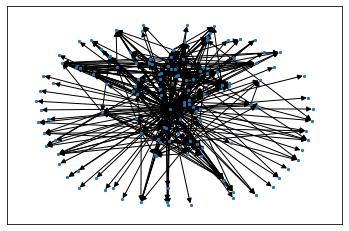

In [61]:
nx.draw_networkx(graph_man, with_labels = False, node_size = 5)

In [62]:
print(f"number of nodes: {graph_man.number_of_nodes()}")
print(f"number of edges: {graph_man.number_of_edges()}")

number of nodes: 131
number of edges: 464


In [63]:
#Degree scores
top_degree_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_man

Top degree scores:


{'http://dbpedia.org/resource/Man': 1.0846153846,
 'http://dbpedia.org/resource/Gender_role': 0.1692307692,
 'http://dbpedia.org/resource/Woman': 0.1615384615,
 "http://dbpedia.org/resource/Men's_rights_movement": 0.1538461538,
 'http://dbpedia.org/resource/Human': 0.1461538462,
 'http://dbpedia.org/resource/Male': 0.1461538462,
 'http://dbpedia.org/resource/Reproductive_system': 0.1461538462,
 'http://dbpedia.org/resource/Puberty': 0.1307692308,
 'http://dbpedia.org/resource/Mammal': 0.1307692308,
 'http://dbpedia.org/resource/Female': 0.1307692308}

In [64]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_man

Top betweeness scores:


{'http://dbpedia.org/resource/Man': 0.3978996176,
 'http://dbpedia.org/resource/Human': 0.2008348241,
 'http://dbpedia.org/resource/Gender_role': 0.0723191924,
 'http://dbpedia.org/resource/Mammal': 0.0251392793,
 'http://dbpedia.org/resource/Culture': 0.0231883749,
 'http://dbpedia.org/resource/Male': 0.0190042214,
 'http://dbpedia.org/resource/Misogyny': 0.0183284351,
 "http://dbpedia.org/resource/Men's_studies": 0.0156003493,
 'http://dbpedia.org/resource/Circumcision': 0.0155919016,
 'http://dbpedia.org/resource/Alcohol_(drug)': 0.0155488353}

In [65]:
top_prestige_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_man

Top prestige scores:


{'http://dbpedia.org/resource/Puberty': 0.2557251908,
 'http://dbpedia.org/resource/Human': 0.2310653833,
 'http://dbpedia.org/resource/Man': 0.2092324337,
 'http://dbpedia.org/resource/DNA': 0.1930072566,
 'http://dbpedia.org/resource/Uterus': 0.1905516347,
 'http://dbpedia.org/resource/Mammal': 0.1898037077,
 'http://dbpedia.org/resource/Müllerian_duct': 0.1875110953,
 'http://dbpedia.org/resource/Carl_Linnaeus': 0.1856818651,
 'http://dbpedia.org/resource/Gender_identity': 0.1819928214,
 'http://dbpedia.org/resource/Prostate': 0.1786451582}

## Woman

In [66]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % woman_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_woman = sparql.query().convert()

# Create an empty directed graph
graph_woman = nx.DiGraph()

# Add 'Man' page to the graph
graph_woman.add_node(woman_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_woman["results"]["bindings"]:
    link = result["link"]["value"]
    graph_woman.add_edge(woman_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_woman = sparql.query().convert()

    # Add the linked page to the graph
    graph_woman.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_woman["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_woman.nodes():
            graph_woman.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

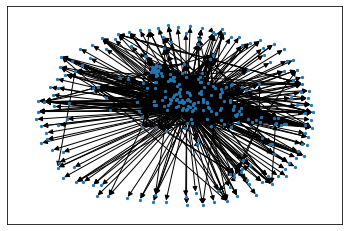

In [67]:
nx.draw_networkx(graph_woman, with_labels = False, node_size = 5)

In [68]:
print(f"number of nodes: {graph_woman.number_of_nodes()}")
print(f"number of edges: {graph_woman.number_of_edges()}")

number of nodes: 307
number of edges: 1324


In [69]:
#Degree scores
top_degree_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_woman

Top degree scores:


{'http://dbpedia.org/resource/Woman': 1.0424836601,
 "http://dbpedia.org/resource/Women's_rights": 0.1568627451,
 'http://dbpedia.org/resource/Violence_against_women': 0.1470588235,
 'http://dbpedia.org/resource/United_Nations': 0.1209150327,
 'http://dbpedia.org/resource/Domestic_violence': 0.1111111111,
 'http://dbpedia.org/resource/Pregnancy': 0.1078431373,
 'http://dbpedia.org/resource/Sexism': 0.1045751634,
 'http://dbpedia.org/resource/Sexual_intercourse': 0.1013071895,
 'http://dbpedia.org/resource/Christianity': 0.091503268,
 'http://dbpedia.org/resource/Marriage': 0.091503268}

In [70]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_woman

Top betweeness scores:


{'http://dbpedia.org/resource/Woman': 0.4596099525,
 'http://dbpedia.org/resource/Pregnancy': 0.175512033,
 'http://dbpedia.org/resource/Human': 0.1058629313,
 'http://dbpedia.org/resource/Burqa': 0.0521289051,
 'http://dbpedia.org/resource/Menstruation': 0.0497830794,
 'http://dbpedia.org/resource/Judaism': 0.0455670271,
 'http://dbpedia.org/resource/Afghanistan': 0.0440592264,
 'http://dbpedia.org/resource/Christianity': 0.0295655318,
 'http://dbpedia.org/resource/France': 0.0287771924,
 'http://dbpedia.org/resource/Misogyny': 0.0260442497}

In [71]:
top_prestige_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_woman

Top prestige scores:


{'http://dbpedia.org/resource/Saudi_Arabia': 0.2148558275,
 'http://dbpedia.org/resource/United_Nations': 0.2121224368,
 'http://dbpedia.org/resource/Christianity': 0.2064007771,
 'http://dbpedia.org/resource/Pregnancy': 0.2037814779,
 'http://dbpedia.org/resource/Judaism': 0.2022415675,
 'http://dbpedia.org/resource/Pew_Research_Center': 0.2019933607,
 'http://dbpedia.org/resource/Menstruation': 0.188473949,
 'http://dbpedia.org/resource/Woman': 0.1871559494,
 'http://dbpedia.org/resource/Reproductive_health': 0.1865171852,
 'http://dbpedia.org/resource/Puberty': 0.184151152}

## Male

In [72]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % male_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_male = sparql.query().convert()

# Create an empty directed graph
graph_male = nx.DiGraph()

# Add 'Man' page to the graph
graph_male.add_node(male_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_male["results"]["bindings"]:
    link = result["link"]["value"]
    graph_male.add_edge(male_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_male = sparql.query().convert()

    # Add the linked page to the graph
    graph_male.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_male["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_male.nodes():
            graph_male.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

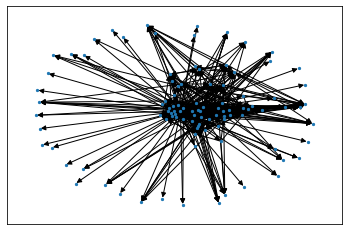

In [73]:
nx.draw_networkx(graph_male, with_labels = False, node_size = 5)

In [74]:
print(f"number of nodes: {graph_male.number_of_nodes()}")
print(f"number of edges: {graph_male.number_of_edges()}")

number of nodes: 102
number of edges: 468


In [75]:
#Degree scores
top_degree_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_male

Top degree scores:


{'http://dbpedia.org/resource/Male': 1.2178217822,
 'http://dbpedia.org/resource/Sex': 0.3663366337,
 'http://dbpedia.org/resource/Female': 0.2475247525,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2277227723,
 'http://dbpedia.org/resource/Gamete': 0.2178217822,
 'http://dbpedia.org/resource/Insect': 0.2178217822,
 'http://dbpedia.org/resource/Animal': 0.1782178218,
 'http://dbpedia.org/resource/Hermaphrodite': 0.1782178218,
 'http://dbpedia.org/resource/Mammal': 0.1683168317,
 'http://dbpedia.org/resource/Chromosome': 0.1683168317}

In [76]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_male

Top betweeness scores:


{'http://dbpedia.org/resource/Male': 0.4633825936,
 'http://dbpedia.org/resource/Bird': 0.0667946723,
 'http://dbpedia.org/resource/Gamete': 0.0587463246,
 'http://dbpedia.org/resource/Sex-determination_system': 0.0271594999,
 'http://dbpedia.org/resource/Female': 0.021470906,
 'http://dbpedia.org/resource/Anisogamy': 0.0205486781,
 'http://dbpedia.org/resource/Convergent_evolution': 0.019515323,
 'http://dbpedia.org/resource/Mars_(mythology)': 0.0194059406,
 'http://dbpedia.org/resource/Gender': 0.0193069307,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.0192342216}

In [77]:
top_prestige_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_male

Top prestige scores:


{'http://dbpedia.org/resource/Carl_Linnaeus': 0.3257177871,
 'http://dbpedia.org/resource/Male': 0.3185294118,
 'http://dbpedia.org/resource/Gamete': 0.2895721925,
 'http://dbpedia.org/resource/Human': 0.2893016856,
 'http://dbpedia.org/resource/Bee': 0.2820450494,
 'http://dbpedia.org/resource/Bird': 0.2794117647,
 'http://dbpedia.org/resource/Fertilization': 0.2681332696,
 'http://dbpedia.org/resource/Anisogamy': 0.2676717746,
 'http://dbpedia.org/resource/Hymenoptera': 0.2659709045,
 'http://dbpedia.org/resource/Animal': 0.2589670014}

## Female

In [78]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % female_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_female = sparql.query().convert()

# Create an empty directed graph
graph_female = nx.DiGraph()

# Add 'Man' page to the graph
graph_female.add_node(female_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_female["results"]["bindings"]:
    link = result["link"]["value"]
    graph_female.add_edge(female_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_female = sparql.query().convert()

    # Add the linked page to the graph
    graph_female.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_female["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_female.nodes():
            graph_female.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

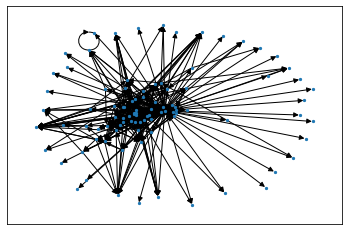

In [79]:
nx.draw_networkx(graph_female, with_labels = False, node_size = 5)

In [80]:
print(f"number of nodes: {graph_female.number_of_nodes()}")
print(f"number of edges: {graph_female.number_of_edges()}")

number of nodes: 96
number of edges: 411


In [81]:
#Degree scores
top_degree_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_female

Top degree scores:


{'http://dbpedia.org/resource/Female': 1.2736842105,
 'http://dbpedia.org/resource/Male': 0.4,
 'http://dbpedia.org/resource/Sex': 0.3157894737,
 'http://dbpedia.org/resource/Gamete': 0.2526315789,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2421052632,
 'http://dbpedia.org/resource/Chromosome': 0.2,
 'http://dbpedia.org/resource/XY_sex-determination_system': 0.2,
 'http://dbpedia.org/resource/Y_chromosome': 0.1894736842,
 'http://dbpedia.org/resource/Mammal': 0.1789473684,
 'http://dbpedia.org/resource/Hermaphrodite': 0.1789473684}

In [82]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_female

Top betweeness scores:


{'http://dbpedia.org/resource/Female': 0.4855586015,
 'http://dbpedia.org/resource/Gamete': 0.0764984794,
 'http://dbpedia.org/resource/Sex-determination_system': 0.0295486904,
 'http://dbpedia.org/resource/Reproduction': 0.0295351168,
 'http://dbpedia.org/resource/Mammal': 0.0265003054,
 'http://dbpedia.org/resource/Turner_syndrome': 0.0223564714,
 'http://dbpedia.org/resource/Anisogamy': 0.0191076862,
 'http://dbpedia.org/resource/Chromosome': 0.018943163,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.0169873548,
 'http://dbpedia.org/resource/Gonochorism': 0.0114341261}

In [83]:
top_prestige_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_female

Top prestige scores:


{'http://dbpedia.org/resource/Female': 0.3501157407,
 'http://dbpedia.org/resource/Gamete': 0.3316885965,
 'http://dbpedia.org/resource/Human': 0.3214831804,
 'http://dbpedia.org/resource/Chromosome': 0.2944898754,
 'http://dbpedia.org/resource/Anisogamy': 0.2890863914,
 'http://dbpedia.org/resource/Monotreme': 0.2868114407,
 'http://dbpedia.org/resource/Sex-determination_system': 0.2864583333,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2838776276,
 'http://dbpedia.org/resource/Cell_(biology)': 0.2740036232,
 'http://dbpedia.org/resource/Ovum': 0.2722222222}

## Non-Binary

In [84]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % non_binary_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_non_binary = sparql.query().convert()

# Create an empty directed graph
graph_non_binary = nx.DiGraph()

# Add 'Man' page to the graph
graph_non_binary.add_node(non_binary_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_non_binary["results"]["bindings"]:
    link = result["link"]["value"]
    graph_non_binary.add_edge(non_binary_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_non_binary = sparql.query().convert()

    # Add the linked page to the graph
    graph_non_binary.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_non_binary["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_non_binary.nodes():
            graph_non_binary.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

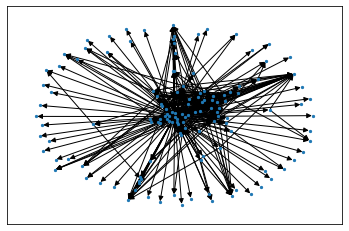

In [85]:
nx.draw_networkx(graph_non_binary, with_labels = False, node_size = 5)

In [86]:
print(f"number of nodes: {graph_non_binary.number_of_nodes()}")
print(f"number of edges: {graph_non_binary.number_of_edges()}")

number of nodes: 134
number of edges: 414


In [87]:
#Degree scores
top_degree_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_non_binary

Top degree scores:


{'http://dbpedia.org/resource/Non-binary_gender': 1.1729323308,
 'http://dbpedia.org/resource/Transgender': 0.2105263158,
 'http://dbpedia.org/resource/Gender_identity': 0.2030075188,
 'http://dbpedia.org/resource/Intersex': 0.1578947368,
 'http://dbpedia.org/resource/Gender': 0.1503759398,
 'http://dbpedia.org/resource/Gender_binary': 0.1428571429,
 'http://dbpedia.org/resource/Third_gender': 0.1353383459,
 'http://dbpedia.org/resource/Gender_role': 0.1203007519,
 'http://dbpedia.org/resource/X-gender': 0.1203007519,
 'http://dbpedia.org/resource/Gender_expression': 0.1127819549}

In [88]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_non_binary

Top betweeness scores:


{'http://dbpedia.org/resource/Non-binary_gender': 0.4094353012,
 'http://dbpedia.org/resource/Gender_identity': 0.0678513474,
 'http://dbpedia.org/resource/Judith_Butler': 0.0338459786,
 'http://dbpedia.org/resource/Gender_binary': 0.0288826356,
 'http://dbpedia.org/resource/Transgender': 0.0280303995,
 'http://dbpedia.org/resource/Gender-neutral_language': 0.0202067669,
 'http://dbpedia.org/resource/Gender_role': 0.0196219688,
 'http://dbpedia.org/resource/Third_gender': 0.0170283785,
 'http://dbpedia.org/resource/Transphobia': 0.0156191344,
 'http://dbpedia.org/resource/2021_Canadian_census': 0.0149806334}

In [89]:
top_prestige_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_non_binary

Top prestige scores:


{'http://dbpedia.org/resource/Intersex': 0.2826735886,
 'http://dbpedia.org/resource/Non-binary_gender': 0.2659967489,
 'http://dbpedia.org/resource/United_States': 0.2484604947,
 'http://dbpedia.org/resource/Gender': 0.2398720682,
 'http://dbpedia.org/resource/Gender_identity': 0.2377493066,
 'http://dbpedia.org/resource/Queer': 0.2284771793,
 'http://dbpedia.org/resource/Judith_Butler': 0.2257619466,
 'http://dbpedia.org/resource/Gender_binary': 0.2202104233,
 'http://dbpedia.org/resource/Gender_expression': 0.2166586423,
 'http://dbpedia.org/resource/Intersex_Society_of_North_America': 0.2037810945}

## Merged graph

In [90]:
parql = SPARQLWrapper("http://dbpedia.org/sparql")  # DBpedia SPARQL endpoint
resource_uri = ["http://dbpedia.org/resource/Woman", 
               "http://dbpedia.org/resource/Man",
               "http://dbpedia.org/resource/Female",
               "http://dbpedia.org/resource/Male",
               "http://dbpedia.org/resource/Non-binary_gender"]  # Resource URI for 'Man' page

def get_graph_from_url(uri):
    query = """
    SELECT ?link
    WHERE {
      <%s> dbo:wikiPageWikiLink ?link .
    }
    """ % uri

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    results = sparql.query().convert()

    # Create an empty directed graph
    graph = nx.DiGraph()
    
    # Add 'Man' page to the graph
    graph.add_node(uri)

    # Iterate through the results and add nodes and edges to the graph
    for result in results["results"]["bindings"]:
        link = result["link"]["value"]
        graph.add_edge(uri, link)

        # Query the linked page for its outgoing links
        query_linked_page = """
        SELECT ?linkedLink
        WHERE {
          <%s> dbo:wikiPageWikiLink ?linkedLink .
        }
        """ % link

        sparql.setQuery(query_linked_page)
        sparql.setReturnFormat(JSON)

        linked_results = sparql.query().convert()

        # Add the linked page to the graph
        graph.add_node(link)

        # Add edges between the linked page and its outgoing links
        for linked_result in linked_results["results"]["bindings"]:
            linked_link = linked_result["linkedLink"]["value"]
            if linked_link in graph.nodes():
                graph.add_edge(link, linked_link)
    return graph


# Create an empty directed graph
graph = nx.DiGraph()

for uri in resource_uri:
    tmp_graph = get_graph_from_url(uri)
    graph.add_nodes_from(tmp_graph.nodes())
    graph.add_edges_from(tmp_graph.edges())

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

In [91]:
print(f"number of nodes: {graph.number_of_nodes()}")
print(f"number of edges: {graph.number_of_edges()}")
print("Density of the directed graph:", nx.density(graph))

number of nodes: 652
number of edges: 2719
Density of the directed graph: 0.006405906910557613


In [92]:
top_degree_scores = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores

Top degree scores:


{'http://dbpedia.org/resource/Woman': 0.4915514593,
 'http://dbpedia.org/resource/Non-binary_gender': 0.2396313364,
 'http://dbpedia.org/resource/Man': 0.2181259601,
 'http://dbpedia.org/resource/Female': 0.2150537634,
 'http://dbpedia.org/resource/Male': 0.198156682,
 "http://dbpedia.org/resource/Women's_rights": 0.0737327189,
 'http://dbpedia.org/resource/Sex': 0.0721966206,
 'http://dbpedia.org/resource/Gender_role': 0.0706605223,
 'http://dbpedia.org/resource/Violence_against_women': 0.069124424,
 'http://dbpedia.org/resource/Human': 0.0675883257}

In [93]:
top_btw_scores = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top betweeness scores:")
top_btw_scores

Top betweeness scores:


{'http://dbpedia.org/resource/Woman': 0.275038311,
 'http://dbpedia.org/resource/Female': 0.1323029026,
 'http://dbpedia.org/resource/Non-binary_gender': 0.1207312208,
 'http://dbpedia.org/resource/Man': 0.1081090779,
 'http://dbpedia.org/resource/Human': 0.0970292039,
 'http://dbpedia.org/resource/Pregnancy': 0.0842047775,
 'http://dbpedia.org/resource/Gender_identity': 0.0641394272,
 'http://dbpedia.org/resource/Gender_role': 0.0626526518,
 'http://dbpedia.org/resource/Male': 0.0550094724,
 'http://dbpedia.org/resource/Menstruation': 0.0234746738}

In [94]:
top_prestige_scores = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores

Top prestige scores:


{'http://dbpedia.org/resource/Human': 0.1864113168,
 'http://dbpedia.org/resource/Puberty': 0.1862035004,
 'http://dbpedia.org/resource/Woman': 0.1843537968,
 'http://dbpedia.org/resource/Female': 0.1805670701,
 'http://dbpedia.org/resource/Pregnancy': 0.1774968543,
 'http://dbpedia.org/resource/Judaism': 0.1743471189,
 'http://dbpedia.org/resource/Saudi_Arabia': 0.1741676097,
 'http://dbpedia.org/resource/Gender_identity': 0.1736221828,
 'http://dbpedia.org/resource/Man': 0.1732619708,
 'http://dbpedia.org/resource/Intersex': 0.1653708316}

### Divisive Clustering - 5 clusters

In [86]:
graph_undir = graph.to_undirected()
# Divisive Clustering based on Edge Betweenness
clustered = graph_undir.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(clustered) == 5:
        break

print('Number of components: {}'.format(nx.number_connected_components(clustered)))

Number of components: 5


Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Sexual_intercourse
	 http://dbpedia.org/resource/Violence_against_women
	 http://dbpedia.org/resource/Woman
	 http://dbpedia.org/resource/Women's_rights
	 http://dbpedia.org/resource/Pregnancy
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Female
	 http://dbpedia.org/resource/Mammal
	 http://dbpedia.org/resource/XY_sex-determination_system
	 http://dbpedia.org/resource/Sex
	 http://dbpedia.org/resource/Male
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Reproductive_system
	 http://dbpedia.org/resource/Semen
	 http://dbpedia.org/resource/Prostate
	 http://dbpedia.org/resource/Human_penis
	 http://dbpedia.org/resource/Man
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Intersex
	 http://dbpedia.org/resource/Gender
	 http://dbpedia.org/resource/Gender_identity
	 http://dbpe

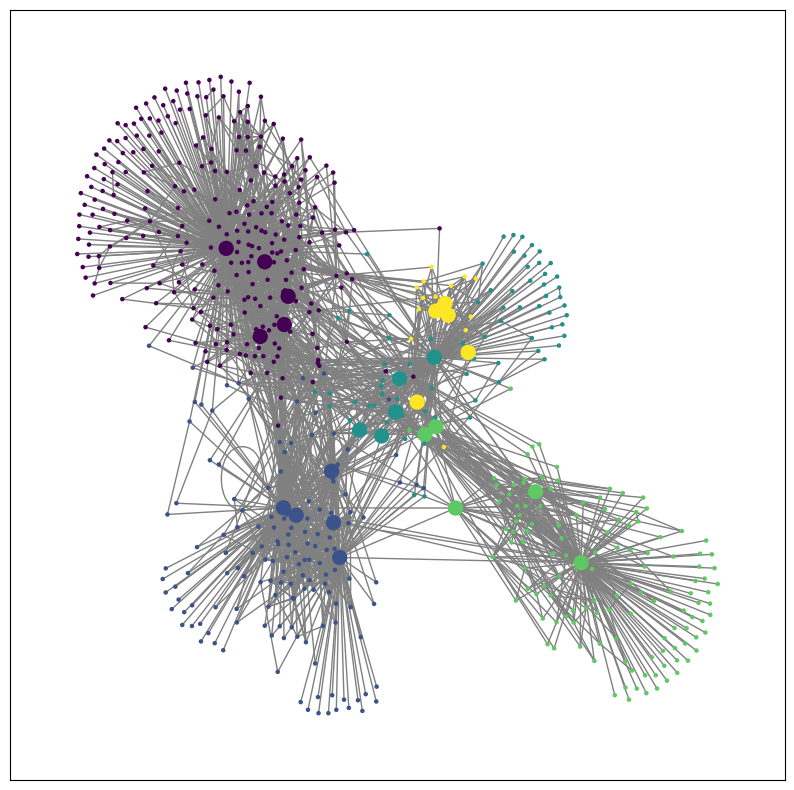

In [95]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in graph_undir.nodes()}
node_color_dict = {v:5 for v in graph_undir.nodes()}
node_size_dict = {v:5 for v in graph_undir.nodes()}

pos = nx.spring_layout(graph_undir, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Pages with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_pages = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_pages:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in graph_undir.nodes()]
node_color = [node_color_dict[v] for v in graph_undir.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(graph_undir, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict
                ,edge_color='grey')

plt.show()

In [ ]:
# Man and woman are clearly different clusters, than female and male are in the same cluster - probably 
# since they are more like biological terms rather than gender terms. 
# And Non-binary with similar topics, gender identity articles are in a same cluster.
# Fifth cluster is masculinity and men's rights. 

#Probably you could try 4 clusters or 6 clusters, idk. And see what kind of clusters we will have. 
#Note: Its not very quick, you will need to wait for a while to ger clusters.

### Divisive Clustering - 4 clusters

In [8]:
graph_undir = graph.to_undirected()
# Divisive Clustering based on Edge Betweenness
clustered = graph_undir.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(clustered) == 4:
        break

print('Number of components: {}'.format(nx.number_connected_components(clustered)))

Number of components: 4


Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Gender_role
	 http://dbpedia.org/resource/Pregnancy
	 http://dbpedia.org/resource/Sexism
	 http://dbpedia.org/resource/Woman
	 http://dbpedia.org/resource/Women's_rights
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Female
	 http://dbpedia.org/resource/Male
	 http://dbpedia.org/resource/Mammal
	 http://dbpedia.org/resource/Sex
	 http://dbpedia.org/resource/XY_sex-determination_system
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Man
	 http://dbpedia.org/resource/Prostate
	 http://dbpedia.org/resource/Semen
	 http://dbpedia.org/resource/Human_penis
	 http://dbpedia.org/resource/Reproductive_system
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Gender_identity
	 http://dbpedia.org/resource/Transgender
	 http://dbpedia.org/resource/Non-binary_gender
	 http://dbpedia.org/r

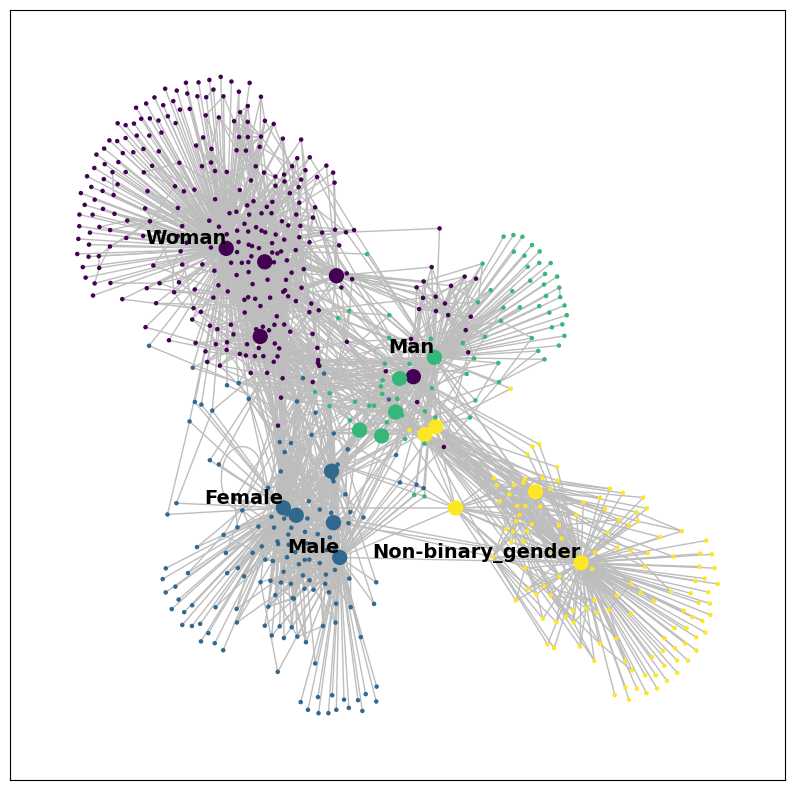

In [80]:
resource_uri = ["http://dbpedia.org/resource/Woman", 
               "http://dbpedia.org/resource/Man",
               "http://dbpedia.org/resource/Female",
               "http://dbpedia.org/resource/Male",
               "http://dbpedia.org/resource/Non-binary_gender"]

# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in graph_undir.nodes()}
node_color_dict = {v:5 for v in graph_undir.nodes()}
node_size_dict = {v:5 for v in graph_undir.nodes()}

pos = nx.spring_layout(graph_undir, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Stops with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_stops = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color
        if node in top_betweeness_score_stops:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            if node in resource_uri:
                node_label_dict[node] = node.split('/')[-1]
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in graph_undir.nodes()]
node_color = [node_color_dict[v] for v in graph_undir.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(graph_undir, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict, font_weight = 'bold' , font_size = 14 #, font_color='tab:brown'
                 ,verticalalignment='bottom', horizontalalignment = 'right'
                ,edge_color='#BDBDBD')
plt.show()

### Divisive Clustering - 6 clusters

In [6]:
graph_undir = graph.to_undirected()
# Divisive Clustering based on Edge Betweenness
clustered = graph_undir.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(clustered) == 6:
        break

print('Number of components: {}'.format(nx.number_connected_components(clustered)))

Number of components: 6


Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Music_education
	 http://dbpedia.org/resource/Classical_music
	 http://dbpedia.org/resource/Composer
	 http://dbpedia.org/resource/Extreme_metal
	 http://dbpedia.org/resource/Woman
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Female
	 http://dbpedia.org/resource/Male
	 http://dbpedia.org/resource/Mammal
	 http://dbpedia.org/resource/Sex
	 http://dbpedia.org/resource/XY_sex-determination_system
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Domestic_violence
	 http://dbpedia.org/resource/Sexual_intercourse
	 http://dbpedia.org/resource/Pregnancy
	 http://dbpedia.org/resource/Women's_rights
	 http://dbpedia.org/resource/Violence_against_women
Stops with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Man
	 http://dbpedia.org/resource/Prostate
	 http://dbpedia.org/resource/Semen
	 ht

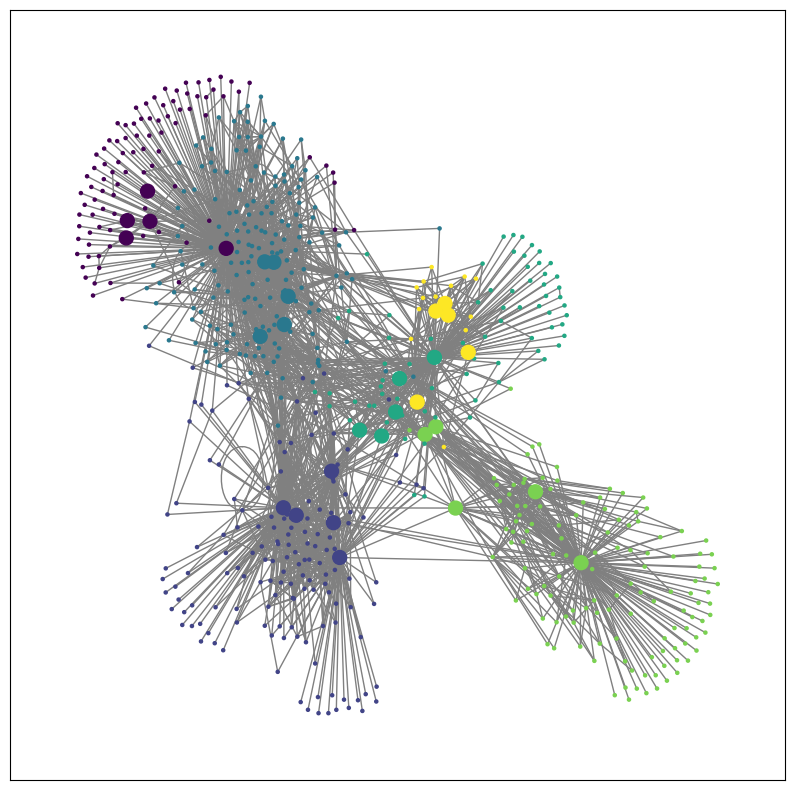

In [7]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in graph_undir.nodes()}
node_color_dict = {v:5 for v in graph_undir.nodes()}
node_size_dict = {v:5 for v in graph_undir.nodes()}

pos = nx.spring_layout(graph_undir, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Stops with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_stops = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_stops:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in graph_undir.nodes()]
node_color = [node_color_dict[v] for v in graph_undir.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(graph_undir, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict
                ,edge_color='grey')
plt.show()

### K-cores clustering with 3 cores

In [ ]:
# Doesn't work that well, only gives us 1 hige component. Not much insighgts here.

In [30]:
graph_undir.remove_edges_from(nx.selfloop_edges(graph_undir))

Component:
	 http://dbpedia.org/resource/American_Psychological_Association
	 http://dbpedia.org/resource/Singapore
	 http://dbpedia.org/resource/Patriarchy
	 http://dbpedia.org/resource/Pregnancy
	 http://dbpedia.org/resource/Secondary_sexual_characteristic
	 http://dbpedia.org/resource/Unicode
	 http://dbpedia.org/resource/Domestic_violence_against_men
	 http://dbpedia.org/resource/Family_law
	 http://dbpedia.org/resource/Men's_health
	 http://dbpedia.org/resource/Ovarian_cancer
	 http://dbpedia.org/resource/Women's_suffrage_in_the_United_States
	 http://dbpedia.org/resource/Motility
	 http://dbpedia.org/resource/Penis
	 http://dbpedia.org/resource/Life_expectancy
	 http://dbpedia.org/resource/Sexual_harassment
	 http://dbpedia.org/resource/Cell_(biology)
	 http://dbpedia.org/resource/Antifeminism
	 http://dbpedia.org/resource/Bell_hooks
	 http://dbpedia.org/resource/Anisogamous
	 http://dbpedia.org/resource/Gonadotropin
	 http://dbpedia.org/resource/X-inactivation
	 http://dbpedia.o

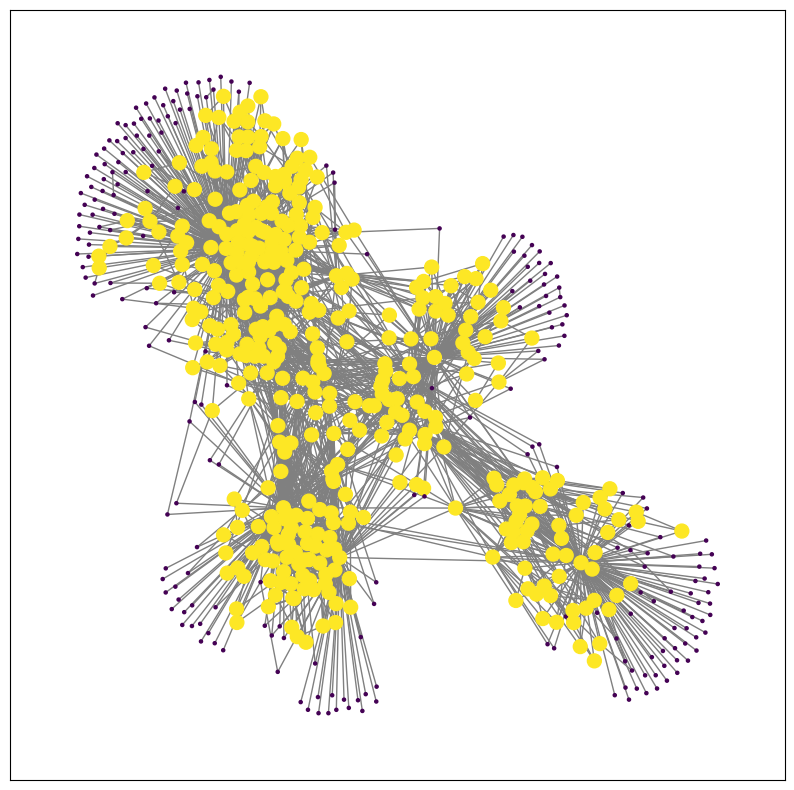

In [31]:
#graph_undir_1 = graph_undir.remove_edges_from(nx.selfloop_edges(graph_undir))
# Use Networkx k_core method with k=3
G_rnv_3_core = nx.k_core(graph_undir, 3)

# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in graph_undir.nodes()}
node_color_dict = {v:5 for v in graph_undir.nodes()}
node_size_dict = {v:5 for v in graph_undir.nodes()}

pos = nx.spring_layout(graph_undir, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_3_core):
    # Change color of nodes with this component
    current_color += 100
    print('Component:')
    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color
        
        print('\t {}'.format(node))
        # Add node label and size for the visualization
        node_label_dict[node] = node
        node_size_dict[node] = 100
    print('')
# Set node size and color of the output network
node_size = [node_size_dict[v] for v in graph_undir.nodes()]
node_color = [node_color_dict[v] for v in graph_undir.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(graph_undir, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict
                ,edge_color='grey')
plt.show()